# Case One: Comparison of the SPB-SFX Model Output for FAST and GM

In [1]:
import os

from wpg.wpg_uti_wf import plot_intensity_map

from felpy.model.tools import scale
from felpy.model.wavefront import Wavefront
from felpy.model.beamlines.exfel_spb.methods import setup_spb
from felpy.analysis.dataset import Dataset

from labwork.about import dCache

from felpy.model.beamline import Beamline
from wpg.optical_elements import Aperture, Drift
from felpy.model.tools import propagation_parameters

from felpy.model.source import SA1_Source, Source_WPG
from felpy.model.mesh import Mesh
from felpy.analysis.statistics.correlation import norm

In [2]:
from felpy.utils.vis_utils import Grids

def kwargs_limit_check(kwargs, ax):
    
    if 'xlim' in kwargs:
        ax.set_xlim(kwargs.get("xlim"))
    if 'ylim' in kwargs:
        ax.set_ylim(kwargs.get("ylim"))
        
def scale_label(scale = 1):
    """ 
    scale label is effectively a smart dictionary for choosing scales in plotting. 
    for now, it is strictly limited to measurements in meters - from micron to m. 
    
    ## this should query a dictionary, or something
    
Number of Nodes    
    :param scale: length scale of the field to be plotted.
    """    
    if  scale == 1:
        return "m"
    elif scale == 1e-02:
        return "cm"
    elif scale == 1e-03:
        return "mm"
    
    elif scale == 1e-06:
        return "$\mu m$"
    else:
        raise Warning("Scale not recognised")

def compare_source_wavefronts(sources, global_aspect = 2, fontsize = 16, scale = 1, labels = None, **kwargs):
    """
    compare the two-dimensional profile of a set of sources
    
    :param sources: list of source elements
    :param fontsize: grid fontsize 
    :param labels: list of labels of length = len(sources)
    """
    
    grid = Grids(scale = 2, global_aspect = global_aspect, context = 'talk')
   

    grid.create_grid(n=1,m=len(sources), sharex = False, sharey = True)
    
    grid.add_global_colorbar("Intensity (a.u.)", fontsize = fontsize, cmap = 'afmhot')

    grid.get_axes()[0].set_ylabel("y ({})".format(scale_label(scale)))
    grid.set_fontsize(fontsize)
    
    if labels is not None:
        if len(sources) != len(labels):
            raise Warning("The length the list of labels should be equal to the number of sources provided")
            
    for itr, src in enumerate(sources):
        
        ax = grid.get_axes()[itr]
        ax.set_xlabel("x ({})".format(scale_label(scale)))
        ax.imshow(src.wfr.get_intensity().sum(-1), cmap = 'afmhot', extent = [val*(1/scale) for val in src.get_mesh_extent()])
    
        if 'xlim' in kwargs:
            ax.set_xlim((a*(1/scale)) for a in kwargs.get("xlim"))
        if 'ylim' in kwargs:
            ax.set_ylim((a*(1/scale)) for a in kwargs.get("ylim"))


    
    return grid

def compare_source_profiles(sources, global_aspect = 2, fontsize = 16, scale = 1, labels = None, **kwargs):
    """
    compare the two-dimensional profile of a set of sources
    
    :param sources: list of source elements
    :param fontsize: grid fontsize 
    :param labels: list of labels of length = len(sources)
    """
    
    grid = Grids(scale = 2, global_aspect = global_aspect, context = 'talk')
    grid.create_grid(n=2,m=1, sharex = False, sharey = True)

    
    grid.get_axes()[0]
    grid.set_fontsize(fontsize)
    
    axes_x, axes_y = grid.get_axes()
    
    if labels is not None:
        if len(sources) != len(labels):
            raise Warning("The length the list of labels should be equal to the number of sources provided")
        
    
    
    for itr, src in enumerate(sources):
        
        ii = src.wfr.get_intensity().sum(-1)
        
        ### note: in this case, axes_x and axes_y refer to the two matplotlib axes elements for which the x- and y-profiles are plotted.
        axes_x.set_xlabel("x ({})".format(scale_label(scale)))
        axes_x.set_ylabel("Intensity (a.u.)")
        axes_x.plot(src.mesh.get_array('x')*(1/scale), norm(ii.mean(0)), label = labels[itr])
        
        axes_y.set_xlabel("y ({})".format(scale_label(scale)))
        axes_y.set_ylabel("Intensity (a.u.)")
        axes_y.plot(src.mesh.get_array('y')*(1/scale), norm(ii.mean(-1)), label = labels[itr])
        
    for ax in grid.get_axes():
        ax.legend()
    

    
    return grid



 


    

## Source Setup

### Generalised Model

In [3]:
mesh = Mesh(nx = 512, ny = 512, xMin = -300e-06, xMax = 300e-06, yMin= -300e-06, yMax= 300e-06)
src_GM = SA1_Source(ekev = 4.98, q = 0.25, S = 1, mesh = mesh)

### FAST Model


In [4]:
DLOC = dCache + "/FAST/4.96keV_250pC_nonlinear/XFEL_S1_04.96keV_12.0GeV_0250pC_SASE_U_BLI_2014-09-04_FAST_FXY1_0001022.h5"

## load wpg wavefront
wfr_FAST  = Wavefront()
wfr_FAST.load_hdf5(DLOC)
wfr_FAST.set_electric_field_representation('frequency')

src_FAST = Source_WPG(wfr = wfr_FAST)

### Comparison

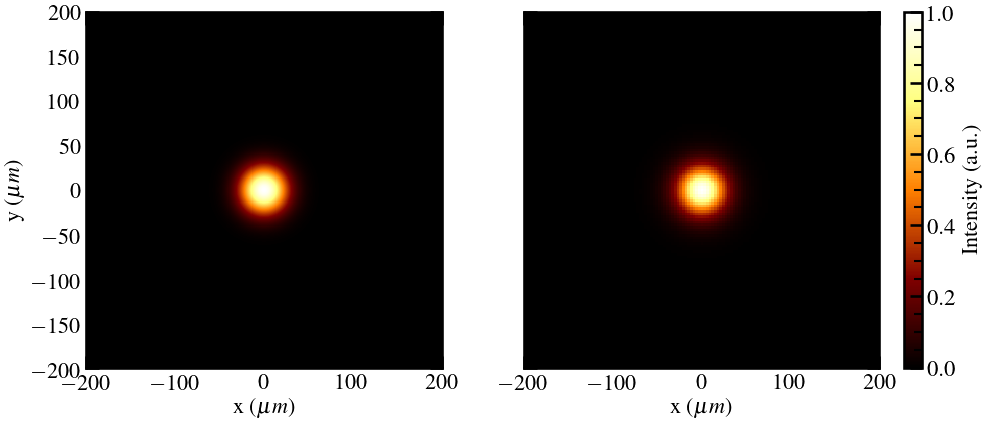

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


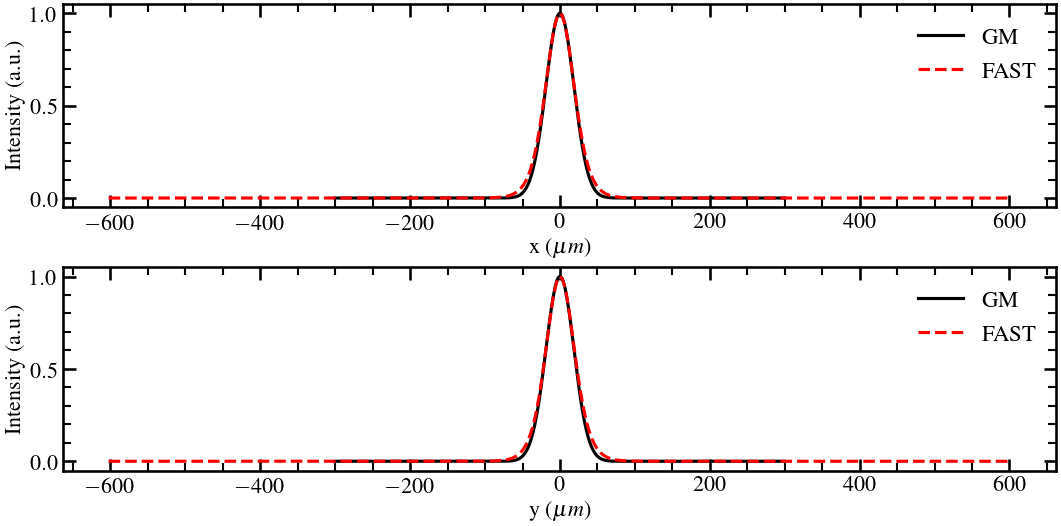

In [5]:
compare_source_wavefronts([src_GM, src_FAST], scale = 1e-06, xlim = (-200e-06, 200e-06), ylim = (-200e-06, 200e-06), global_aspect = 2.5)
compare_source_profiles([src_GM, src_FAST], labels = ["GM", "FAST"], scale = 1e-06)

## Beamline Setup

### Generalised Model

In [6]:
spb_GM = setup_spb(parameter_file = "/gpfs/exfel/data/user/guestt/FELpy/felpy/data/params/spb-sfx_nkb_GM_4.98.json", theta_KB = 5e-03, theta_HOM = 5.0e-03, crop = ['d1'])#bl = spb.bl
spb_GM.edit_propagation_parameters("d1", propagation_parameters(1/5,1,1/5,1,'fraunhofer'))

Initialising Single Particle Beamline
List of Elements: ['d1']


### FAST Model

Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1', 'd2', 'HOM2', 'd3', 'NKB_PSlit', 'd4', 'NHE_error', 'NHE', 'd5', 'NVE_error', 'NVE']
List of Elements: ['d1', 'HOM1', 'd2', 'HOM2', 'd3', 'NKB_PSlit', 'd4', 'NHE_error', 'NHE', 'd5', 'NVE_error', 'NVE']
List of Elements: ['d1', 'HOM1', 'd2', 'HOM2', 'd3', 'NKB_PSlit', 'd4', 'NHE_error', 'NHE', 'd5', 'NVE_error', 'NVE']
List of Elements: ['d1', 'HOM1', 'd2', 'HOM2', 'd3', 'NKB_PSlit', 'd4', 'NHE_error', 'NHE', 'd5', 'NVE_error', 'NVE']
{'d1': {'name': 'd1', 'description': 'Drift from Source to HOM1', 'distance': 46.5, 'pp': [1, 1, 1, 1, 'quadratic']}, 'HOM1': {'name': 'HOM1', 'distance from source': 246.5, 'description': 'First Horizontal Offset Mirror', 'mirror profile': '/gpfs/exfel/data/user/guestt/FELpy//felpy//data/spb/mirror_surface/HOM1_mir_real.dat', 'orientation': 'x', 'incidence angle': 0.005, 'xc': 0, 'yc': 0, 'reflectivity': 0.992391, 'next_drift': 'd2', 'ang_min': 0.0011, 'ang_max': 0.0036, 'dx': 0.525, 

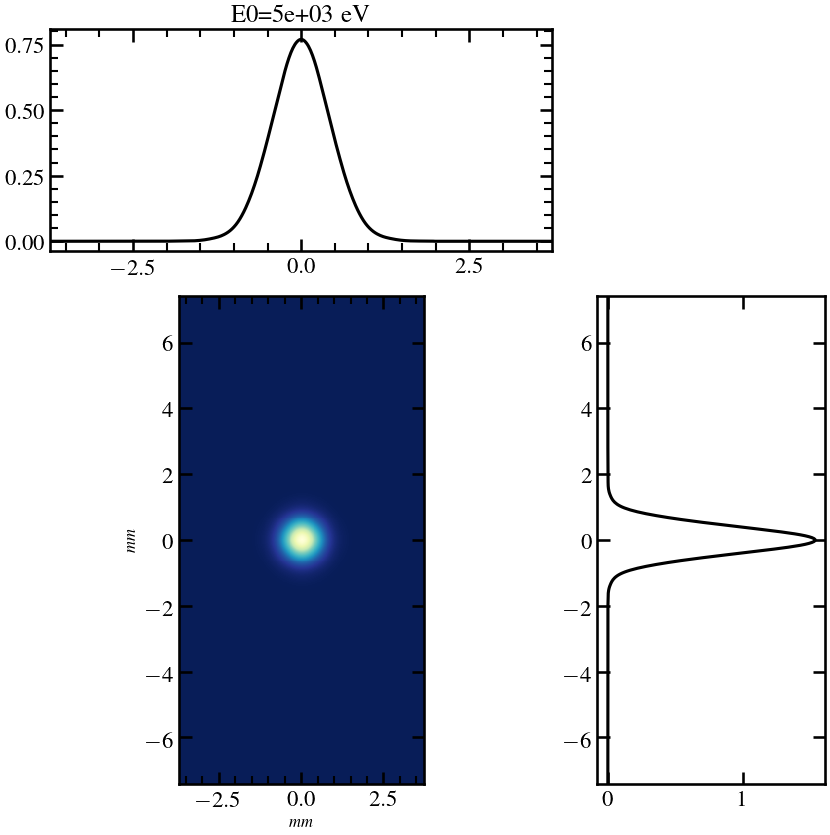

d2


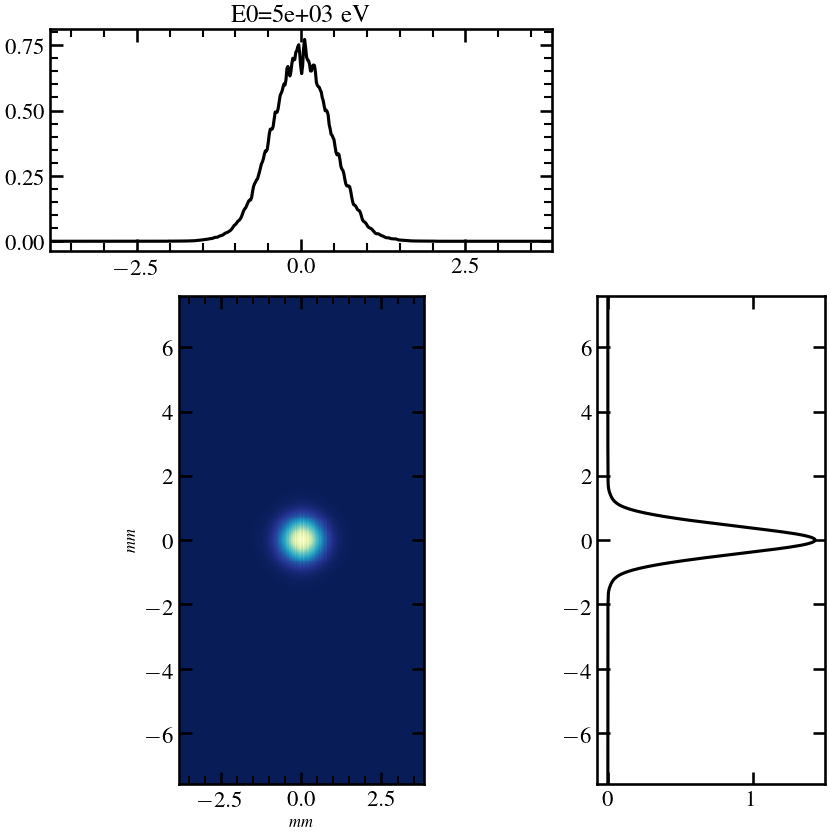

HOM2


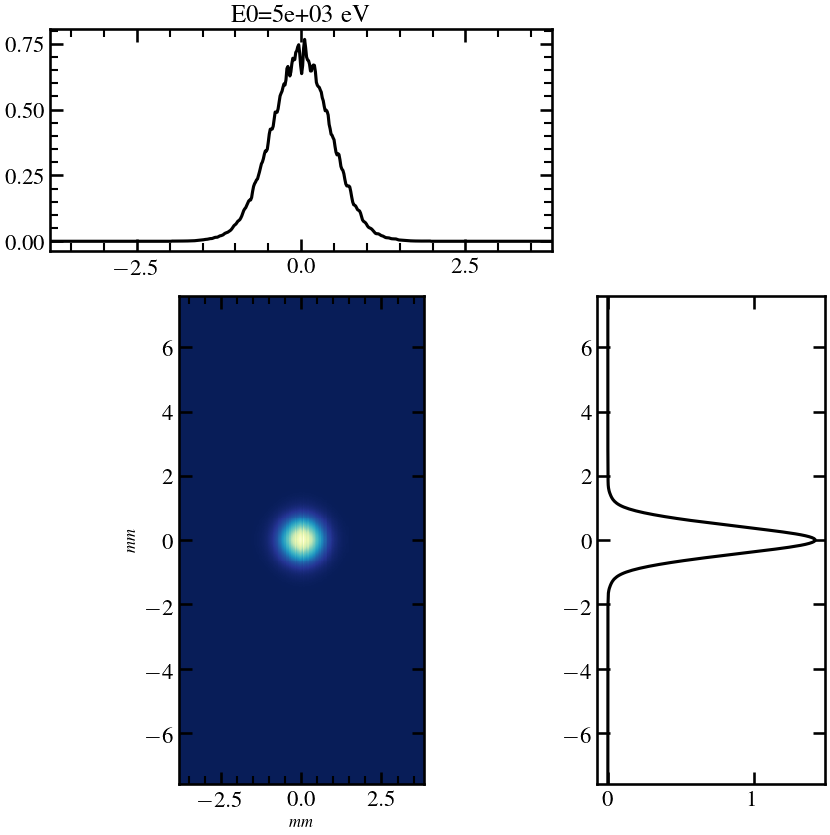

d3


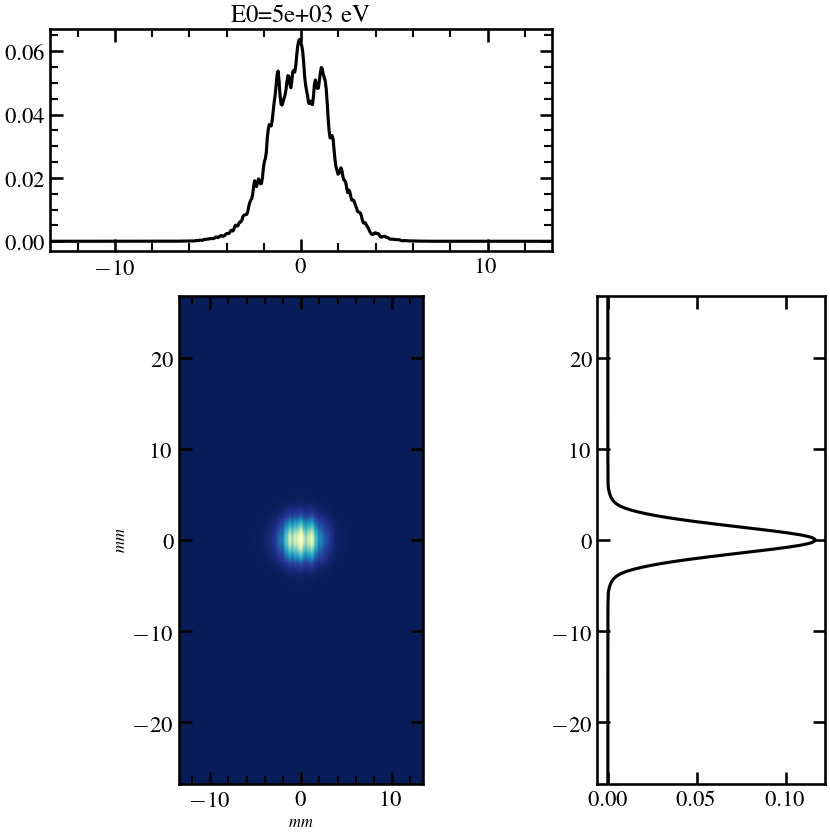

NKB_PSlit


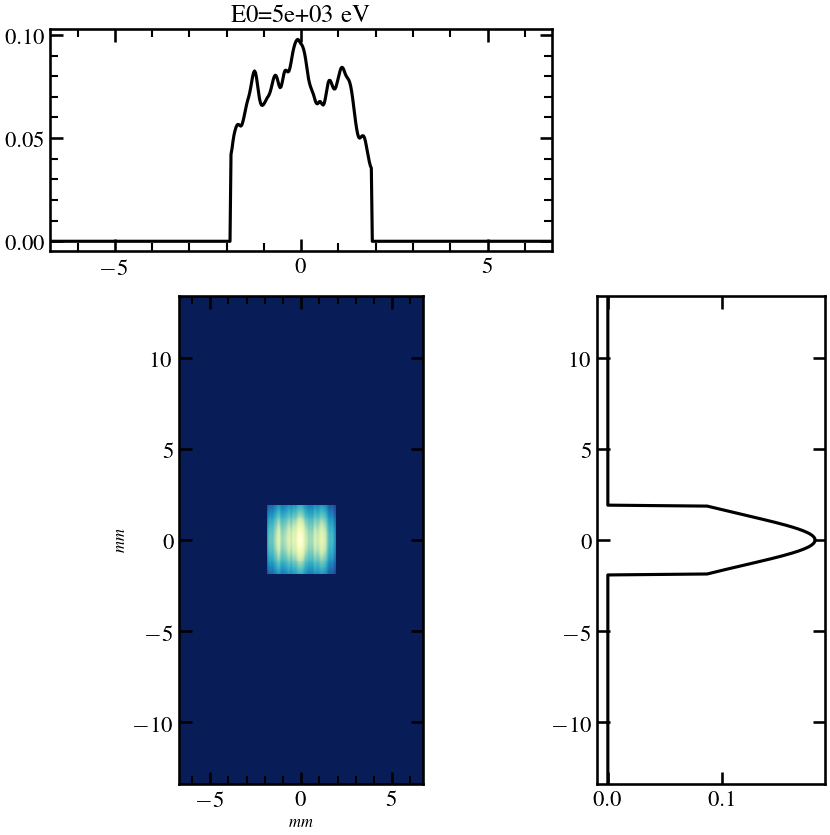

d4


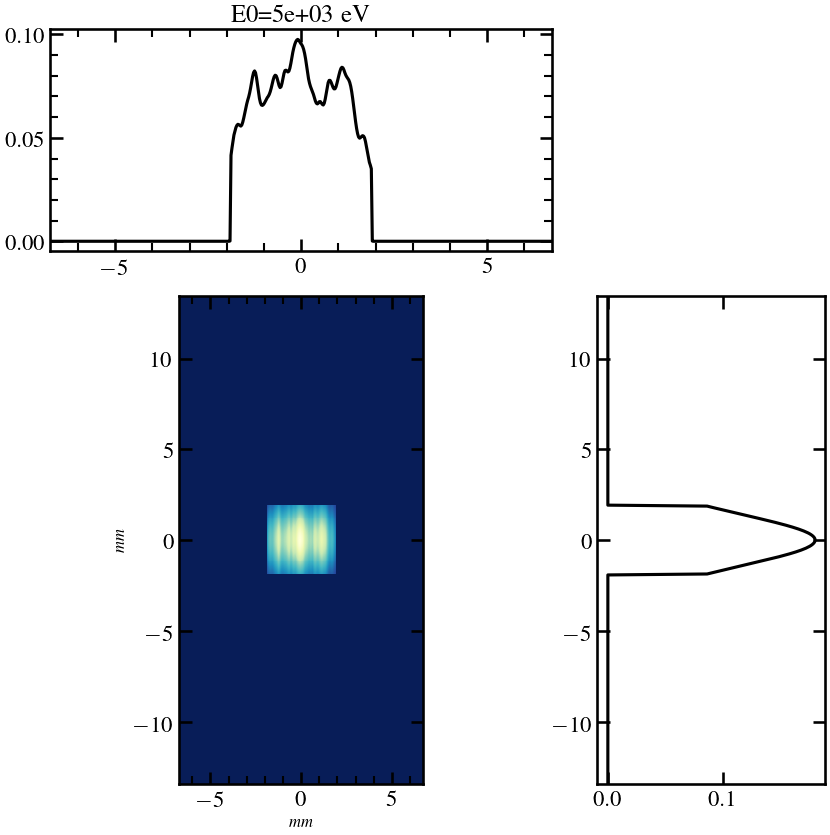

NHE_error


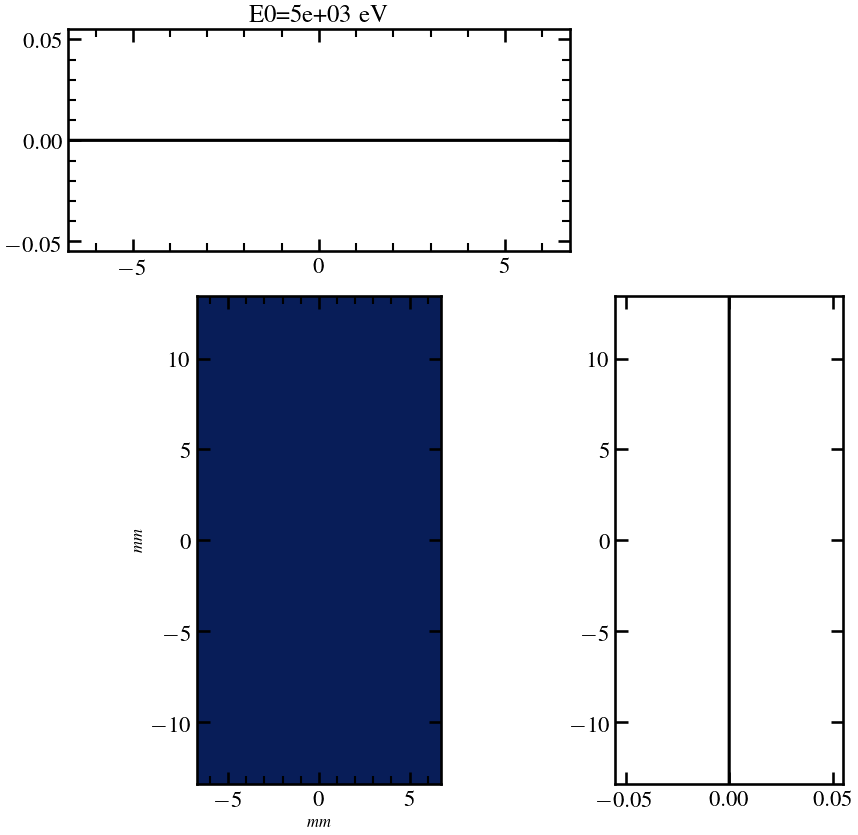

NHE


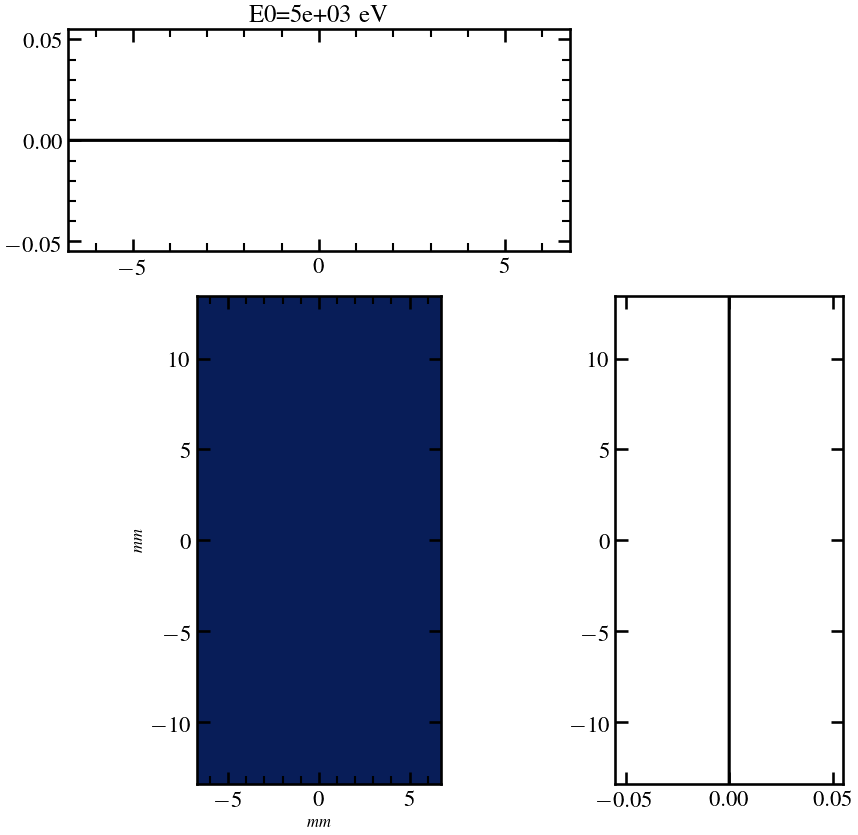

d5


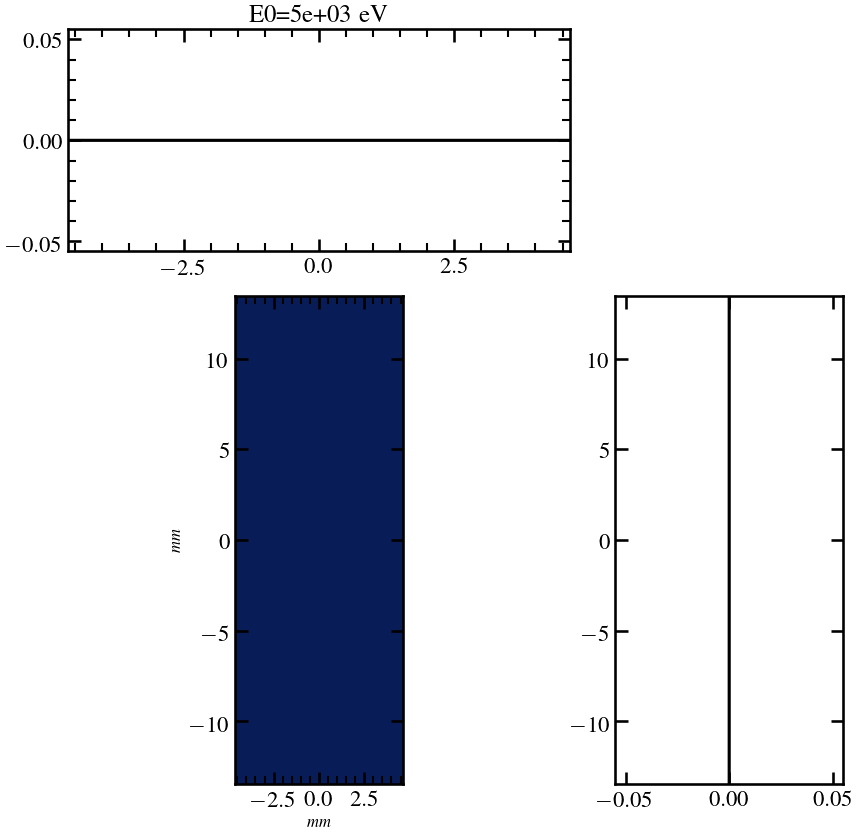

NVE_error


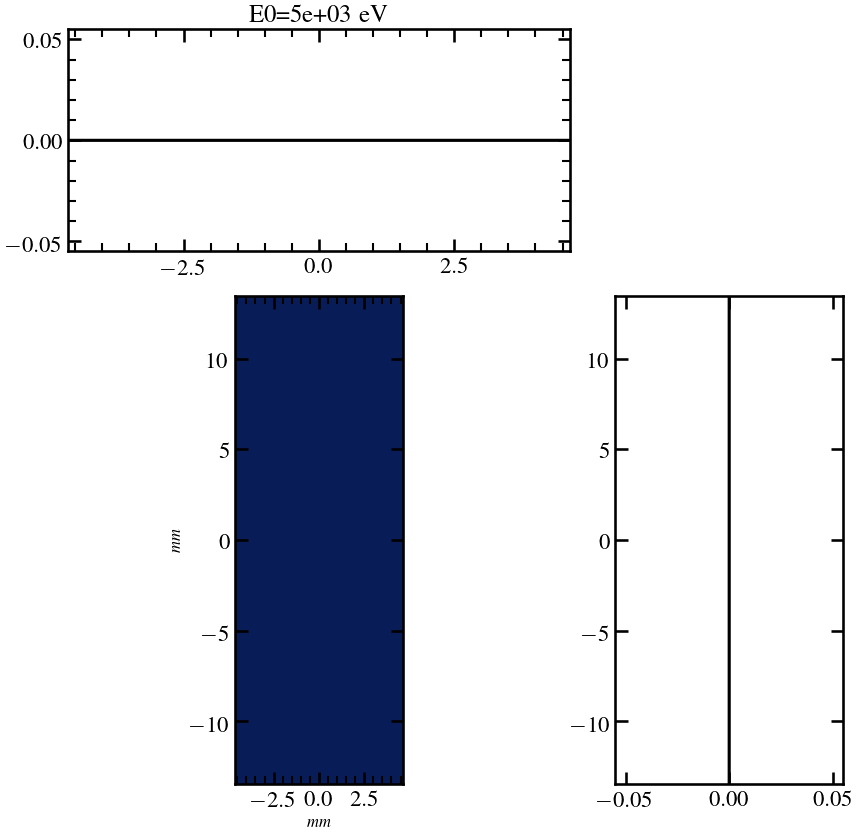

NVE


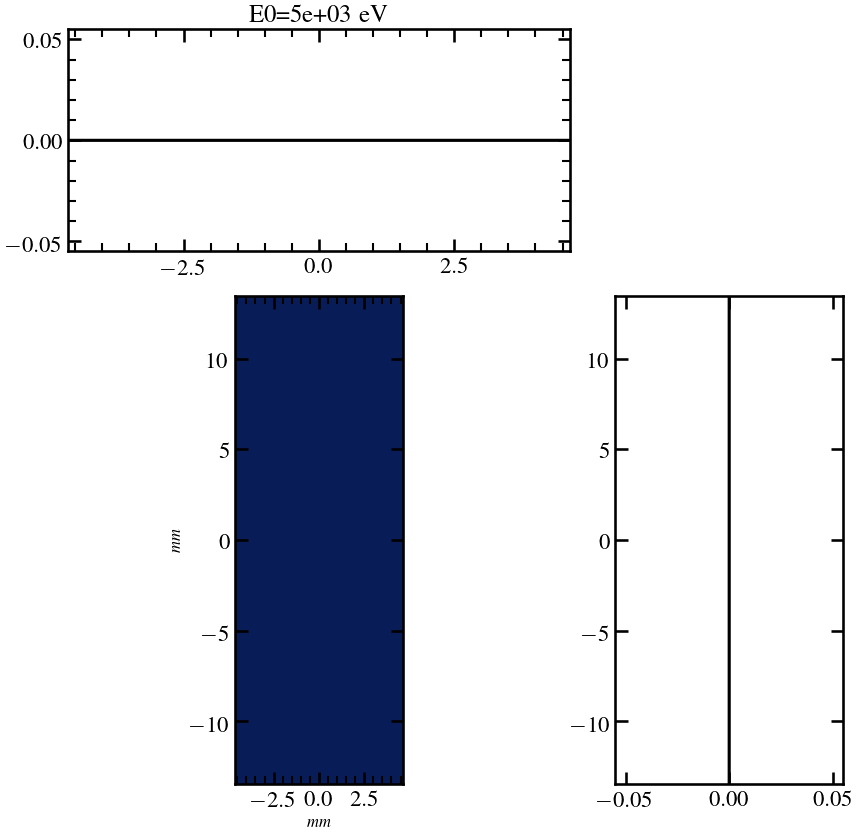

{'ndims': 2, 'nx': 512, 'ny': 512, 'xMin': -0.0003, 'xMax': 0.0003, 'yMin': -0.0003, 'yMax': 0.0003, 'D': ['nx', 'ny', 'xMin', 'xMax', 'yMin', 'yMax', 'nz', 'zMin', 'zMax']}


In [7]:
spb_GM.bl.propagate(src_GM.wfr)

fov_x = src_GM.wfr.params.Mesh.xMax-src_GM.wfr.params.Mesh.xMin
fov_y = src_GM.wfr.params.Mesh.yMax-src_GM.wfr.params.Mesh.yMin

nx = src_GM.mesh.nx
ny = src_GM.mesh.ny

spb = setup_spb(parameter_file = "/gpfs/exfel/data/user/guestt/FELpy/felpy/data/params/spb-sfx_nkb_GM_4.98.json", theta_KB = 5e-03, theta_HOM = 5.0e-03, crop = ['HOM1', 'NVE'])#bl = spb.bl
spb.edit_propagation_parameters("HOM1", propagation_parameters(1/2, 1, 1/2, 1 ,mode = 'fresnel'))
spb.edit_propagation_parameters("NHE_error", propagation_parameters(1,4,1,4, mode = 'fresnel'))
spb.edit_propagation_parameters("d5", propagation_parameters(1, 1, 1, 1 ,mode = 'quadratic'))

spb.remove_element("d1")
#spb.remove_element("NVE_error")
#spb.remove_element("NVE")
#spb.remove_element("d5")
#spb.remove_element("NHE_error")
spb.elements

print(spb.params)
#spb.bl.append(Drift(2.2), propagation_parameters(2,2,2,2, mode = 'converge'))
spb.bl.propagate_sequential(src_GM.wfr)
print(src_GM.mesh.__dict__)
fx,fy = src_GM.wfr.get_fwhm()
src_GM.wfr.store_hdf5("./src_GM.h5")


In [8]:
spb.get_mirror_profile("HOM2")

(array([[3.3514e-11, 6.9261e-11, 9.5541e-11, ..., 4.0027e-10, 3.6518e-10,
         3.1632e-10],
        [3.3514e-11, 6.9261e-11, 9.5541e-11, ..., 4.0027e-10, 3.6518e-10,
         3.1632e-10],
        [3.3514e-11, 6.9261e-11, 9.5541e-11, ..., 4.0027e-10, 3.6518e-10,
         3.1632e-10],
        ...,
        [3.3514e-11, 6.9261e-11, 9.5541e-11, ..., 4.0027e-10, 3.6518e-10,
         3.1632e-10],
        [3.3514e-11, 6.9261e-11, 9.5541e-11, ..., 4.0027e-10, 3.6518e-10,
         3.1632e-10],
        [3.3514e-11, 6.9261e-11, 9.5541e-11, ..., 4.0027e-10, 3.6518e-10,
         3.1632e-10]]),
 array([-5.        , -4.99367089, -4.98734177, ...,  4.98734177,
         4.99367089,  5.        ]),
 array([-394.5, -394. , -393.5, ...,  394. ,  394.5,  395. ]))

## To Focus

None


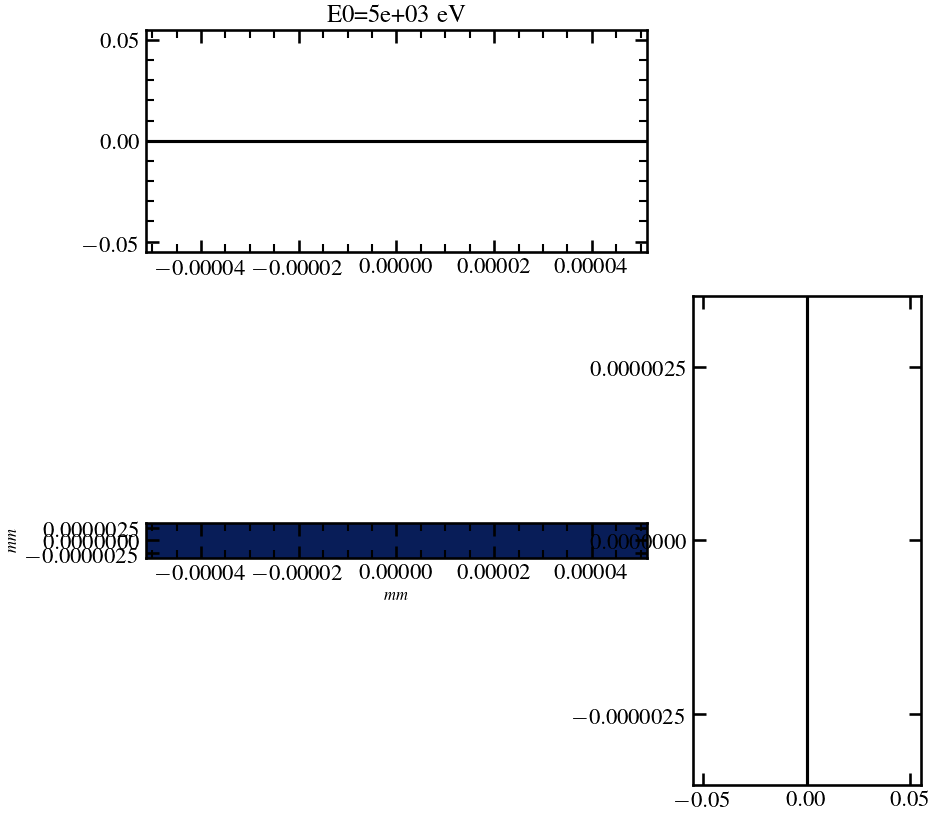

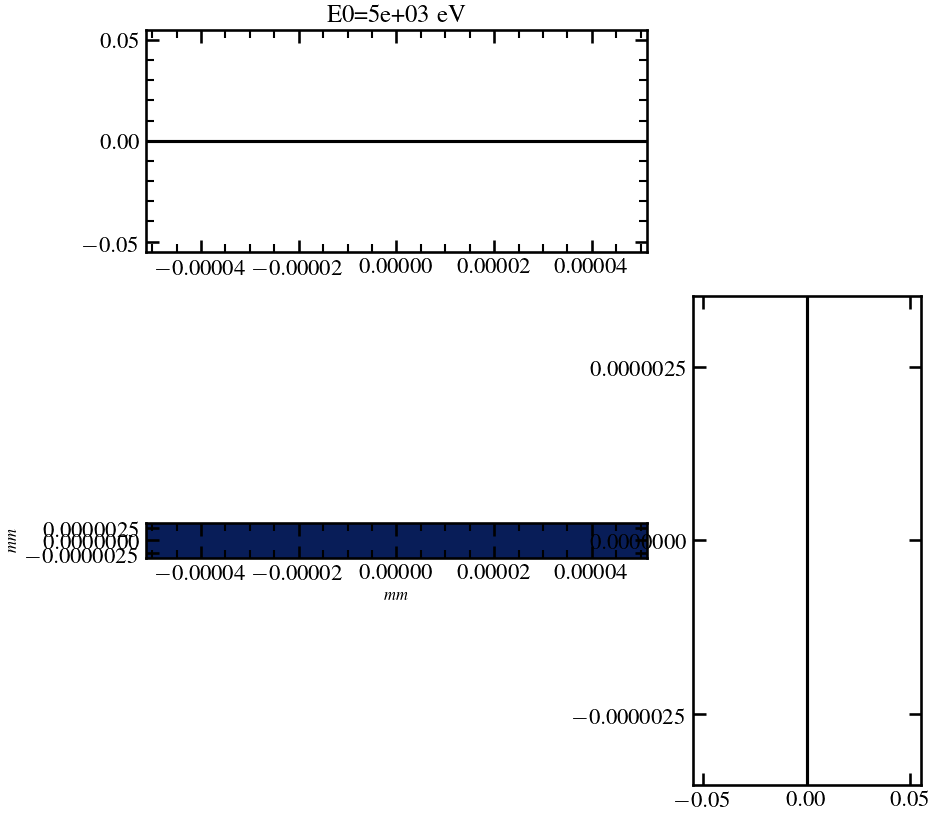

(0.0, 0.0)


In [9]:
from felpy.model.wavefront import Wavefront
from felpy.model.beamline import Beamline
from wpg.optical_elements import Drift
from felpy.model.tools import propagation_parameters
from wpg.wpg_uti_wf import plot_intensity_map

wfr = Wavefront()
wfr.load_hdf5("./src_GM.h5")

bl = Beamline()
bl.append(Drift(2.2), propagation_parameters(1,1/4,1/10,1/4,'quadratic'))
#bl.append(Drift(0.2), propagation_parameters(1,1,1/1,1, mode = 'converge'))
bl.propagate_sequential(wfr)

plot_intensity_map(wfr)
print(wfr.get_fwhm())

In [10]:

sx, sy = src_FAST.wfr.params.Mesh.nx, src_FAST.wfr.params.Mesh.ny
sov_x = src_FAST.wfr.params.Mesh.xMax-src_FAST.wfr.params.Mesh.xMin
sov_y = src_FAST.wfr.params.Mesh.yMax-src_FAST.wfr.params.Mesh.yMin

## load bl object (get_beamline object is a static method of the beamline class)
spb = setup_spb(parameter_file = "/gpfs/exfel/data/user/guestt/FELpy/felpy/data/params/spb-sfx_nkb_GM_4.98.json", theta_KB = 5e-03, theta_HOM = 5e-03)#bl = spb.bl
spb.edit_propagation_parameters("d1", propagation_parameters(1/10, nx/sx, 1/10, ny/sy ,mode = 'fraunhofer'))
spb.edit_propagation_parameters("d5", propagation_parameters(2, 1, 2, 1 ,mode = 'quadratic'))

bl = spb.bl
bl.append(Drift(2.2), propagation_parameters(1,1,1,1, mode = 'converge'))
## EXEC


Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1', 'd2', 'HOM2', 'd3', 'NKB_PSlit', 'd4', 'NHE_error', 'NHE', 'd5', 'NVE_error', 'NVE']
List of Elements: ['d1', 'HOM1', 'd2', 'HOM2', 'd3', 'NKB_PSlit', 'd4', 'NHE_error', 'NHE', 'd5', 'NVE_error', 'NVE']


None
d1


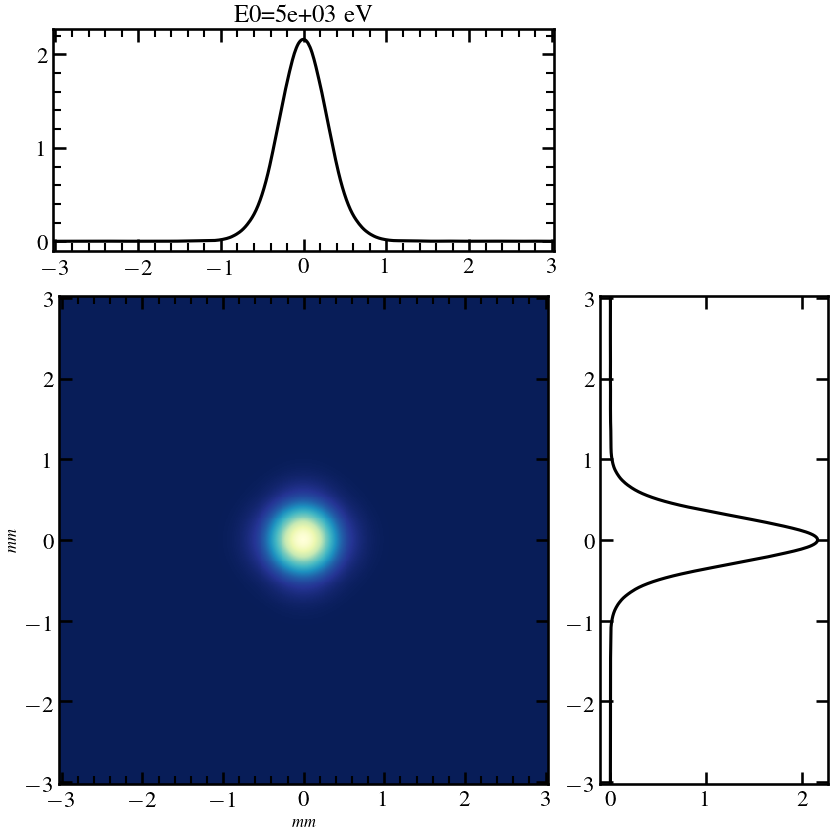

HOM1


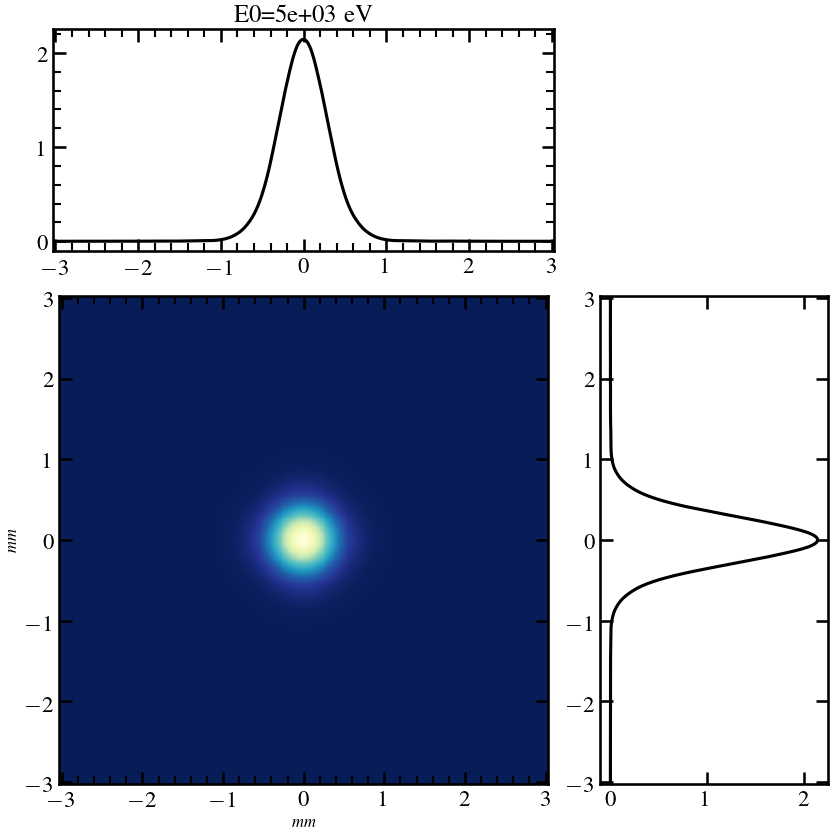

d2


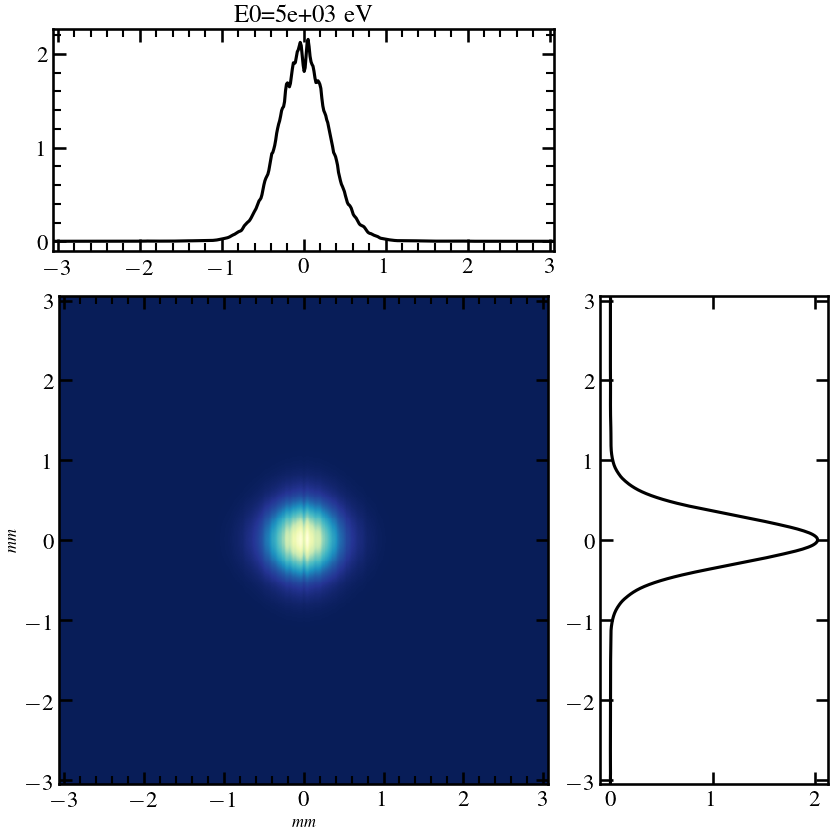

HOM2


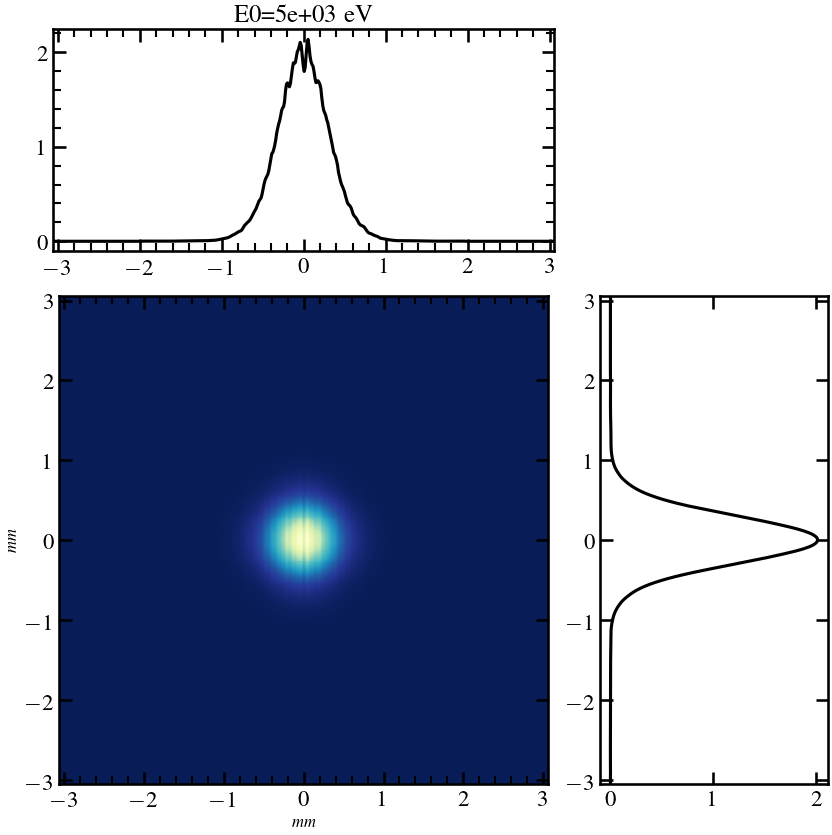

d3


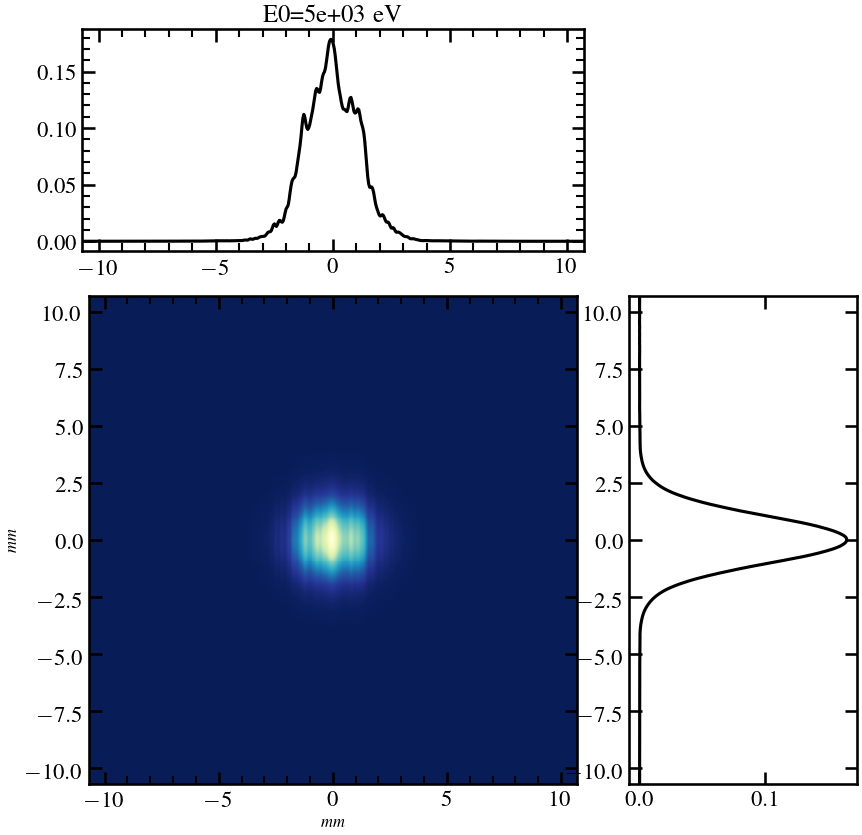

NKB_PSlit


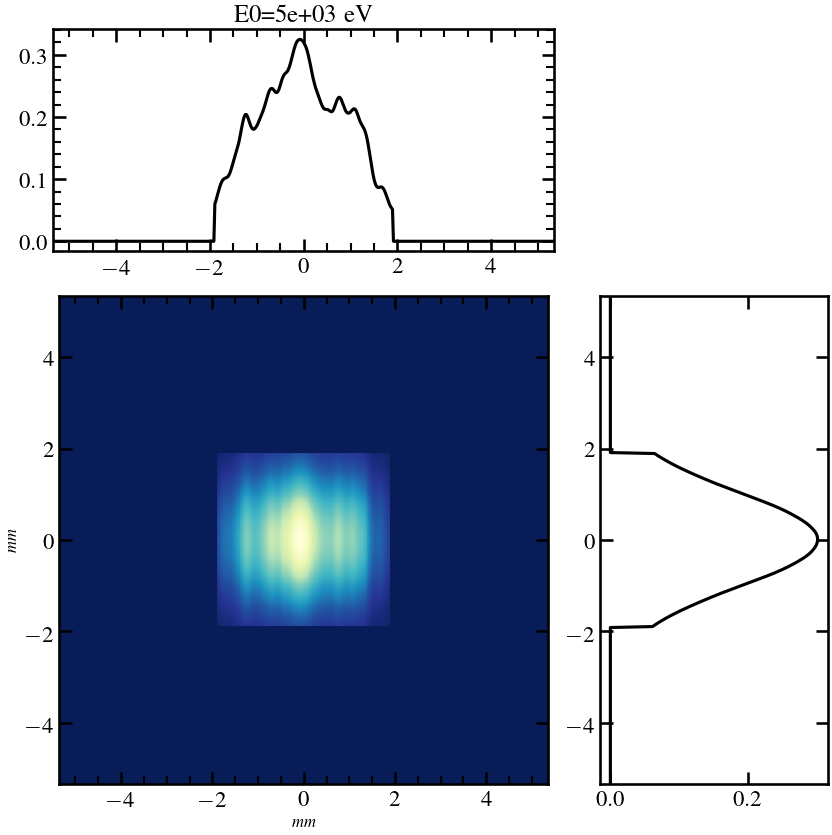

d4


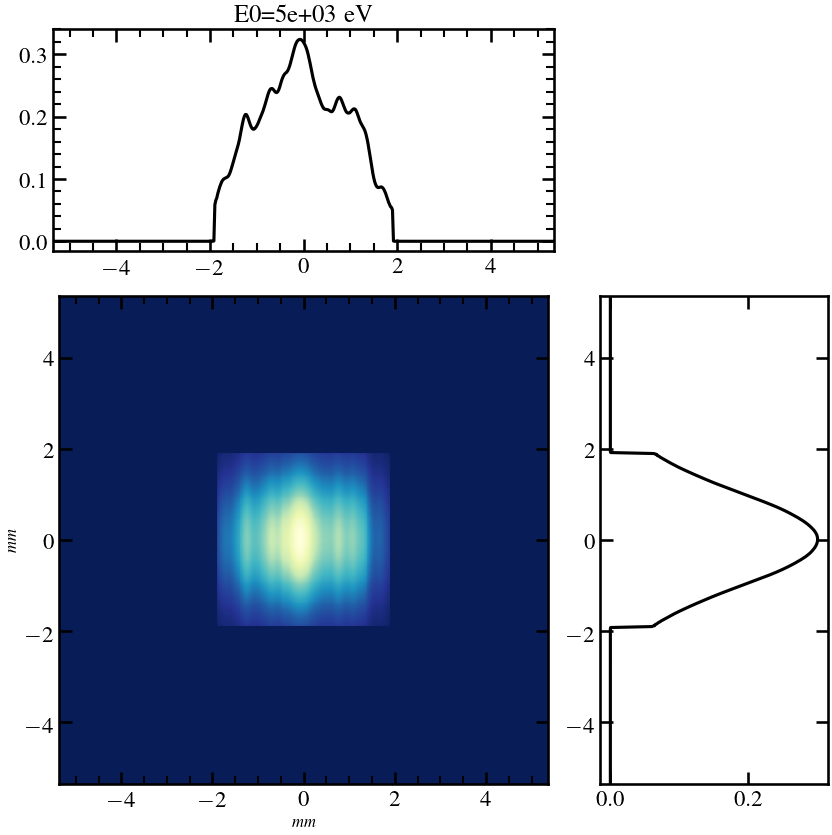

NHE_error


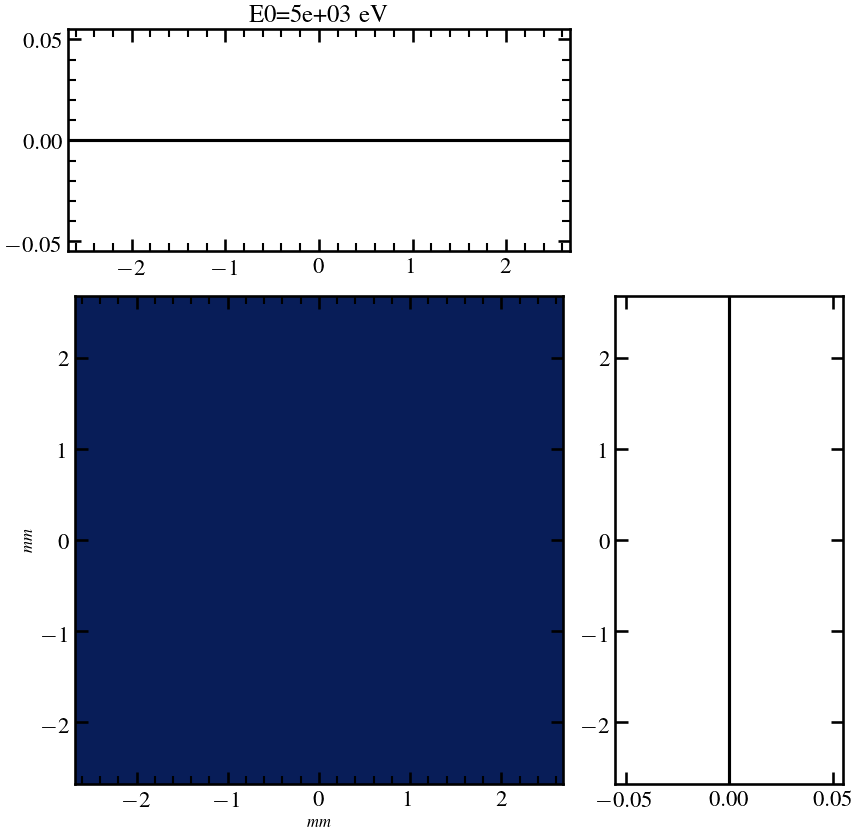

NHE


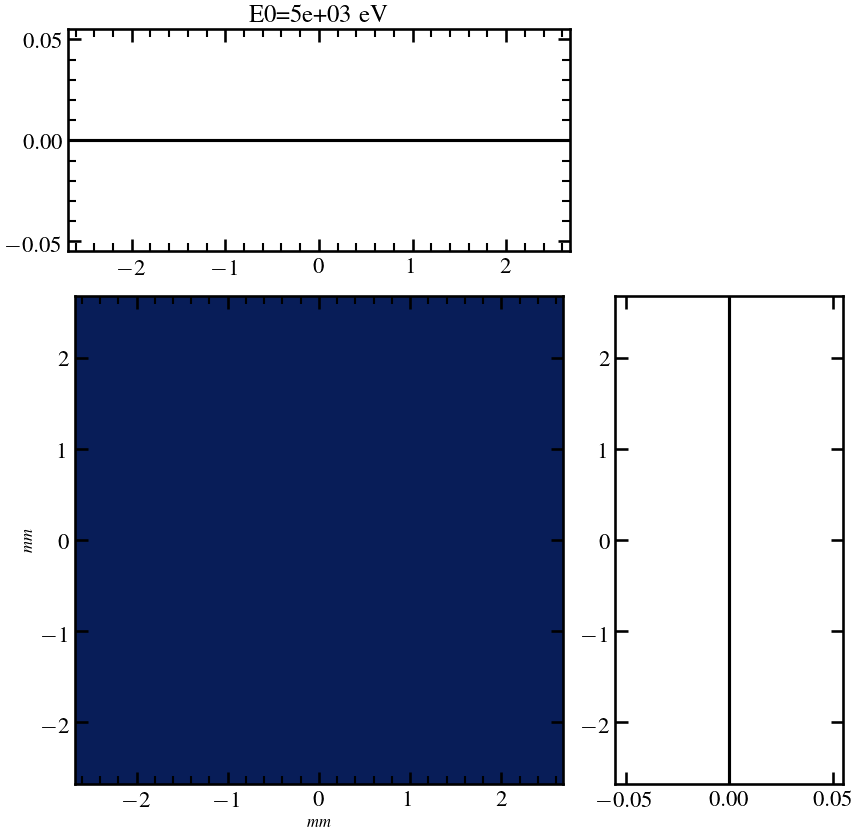

d5


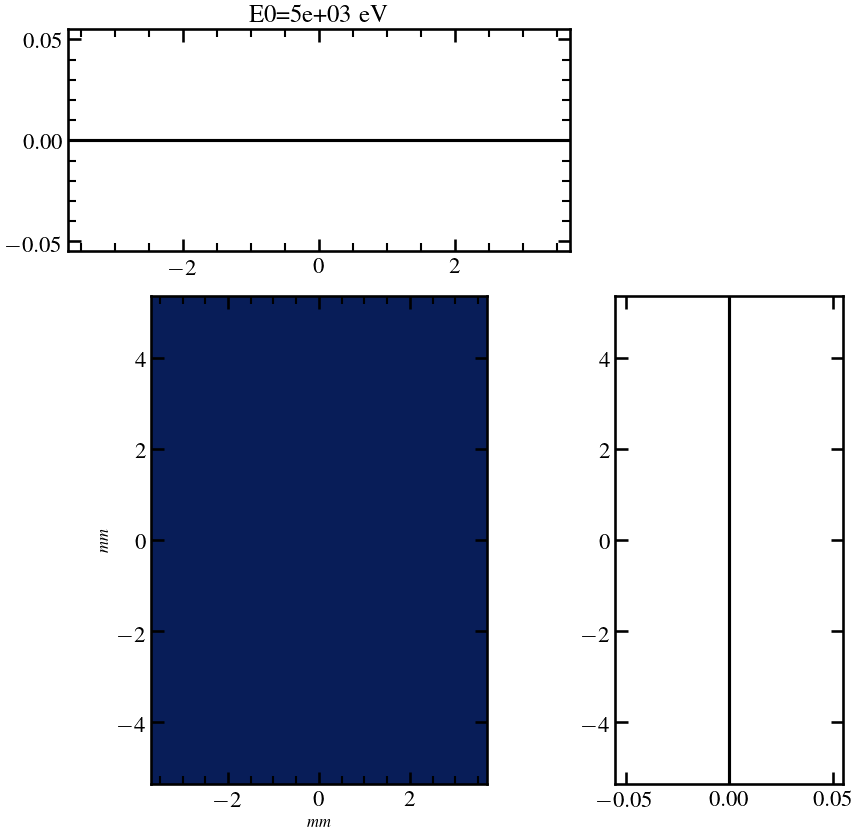

NVE_error


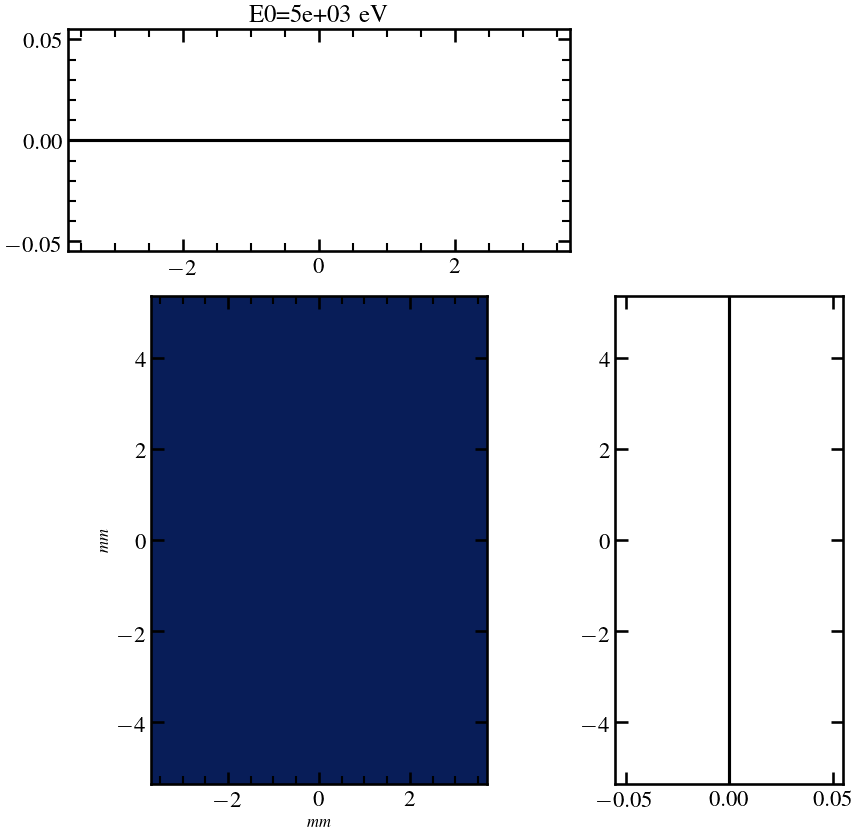

NVE


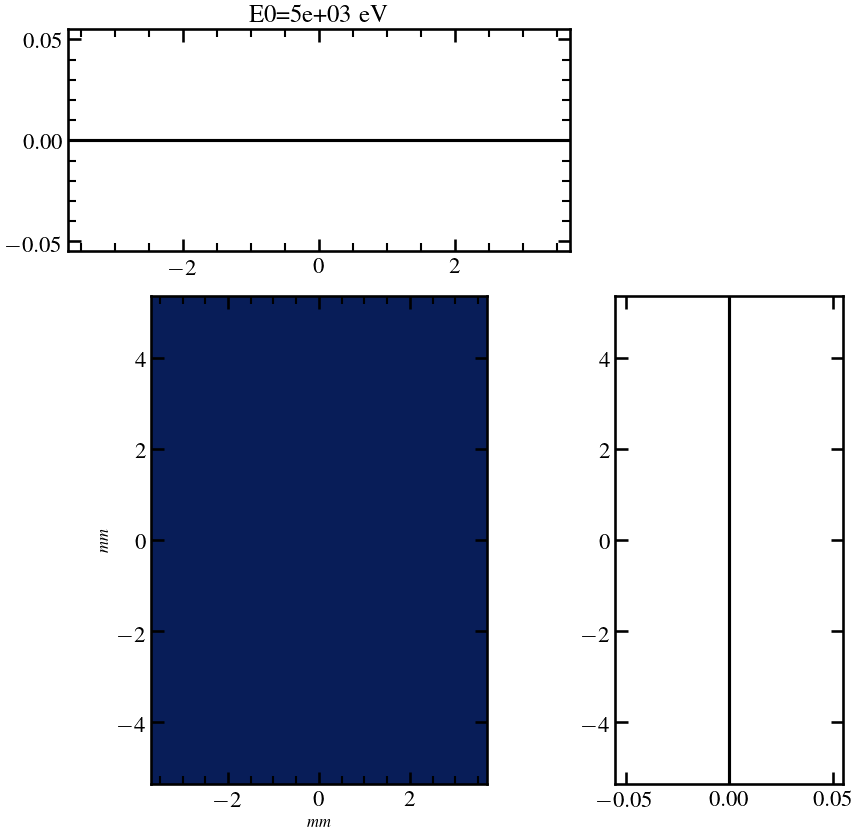

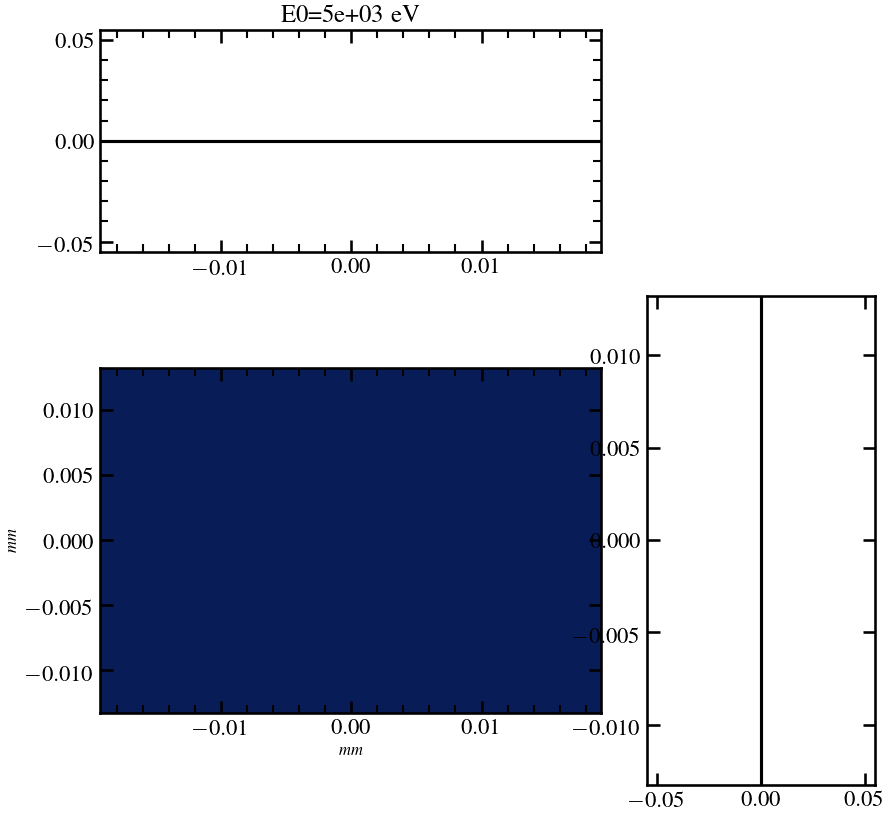

In [11]:
bl.propagate_sequential(wfr_FAST)

ValueError: x and y must have same first dimension, but have shapes (512,) and (2048,)

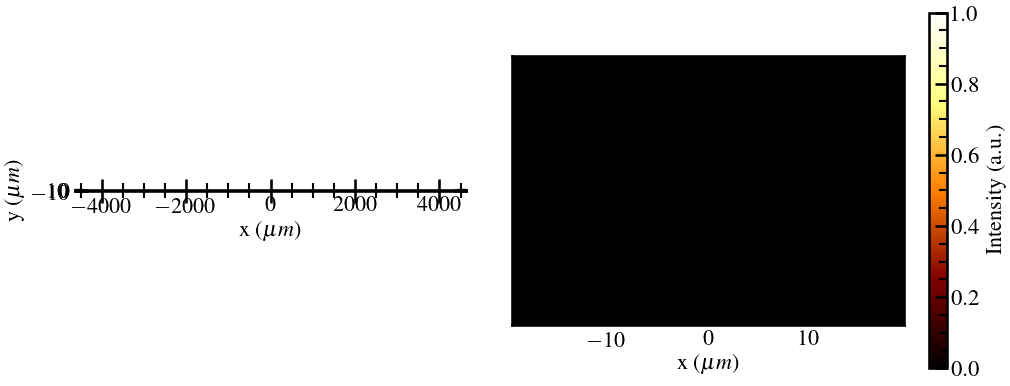

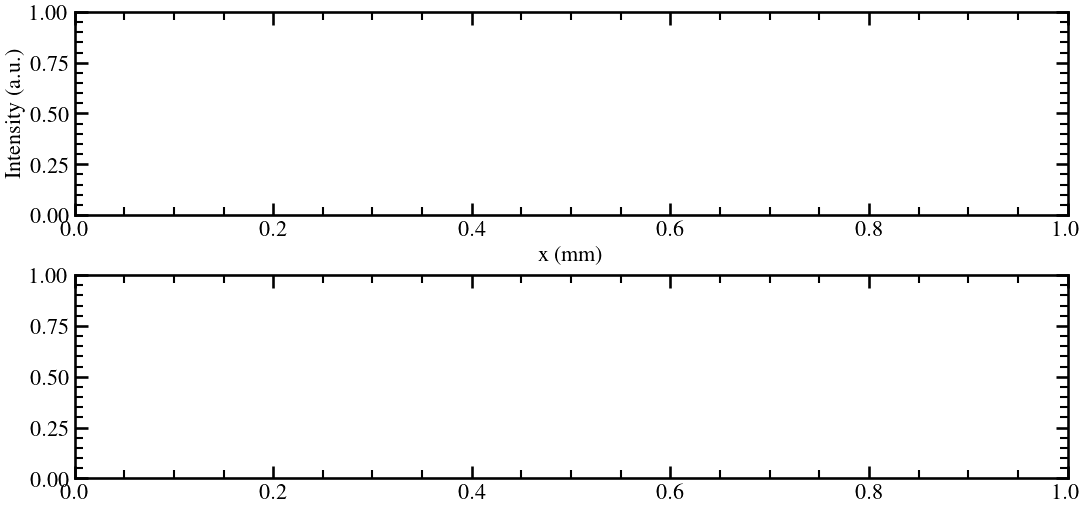

In [12]:
src_FAST.wfr._changed = True
src_FAST.__update__()

compare_source_wavefronts([src_GM, src_FAST], scale = 1e-06, global_aspect = 2.5)
compare_source_profiles([src_GM, src_FAST], labels = ["GM", "FAST"], scale = 1e-03)

In [ ]:
print(src)

In [ ]:
spb.get_mirror_profile("NVE_error")